# Fourth model 

This model will try to predict wether pe is present or not on study level, given 50 scans.

## Imports

In [1]:
import numpy as np
from modules.balance import *
from modules.model import *
from torchsummary import summary

In [3]:
import torch
torch.cuda.empty_cache()

print(f'PyTorch version: {torch.__version__}')
print("GPU found :)" if torch.cuda.is_available() else "No GPU :(")

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

PyTorch version: 1.7.1+cpu
No GPU :(


# Load dataset

In [4]:
multi_image_dataset = torch.load('datasets/multi_image_dataset.pt')
nb_images = 50

## CNN

In [5]:
class ModelV4(nn.Module):
    
    def __init__(self, input_channels=3*nb_images):
        """Convnet with 4 convolution layer + pooling + BN, with 3 fully connected at the end"""
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=256, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(256)
        self.conv2 = nn.Conv2d(256, 512, 3)
        self.bn2 = nn.BatchNorm2d(512)
        self.conv3 = nn.Conv2d(512, 256, 3)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 64, 3)
        self.bn4 = nn.BatchNorm2d(64)
        
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        self.fc1 = nn.Linear(64*14*14 , 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 1)
        
        self.dropout = nn.Dropout(0.5)
        
        self.sigmoid = nn.Sigmoid()
        
        
    def forward(self, x):
        
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = x.view(-1, 64*14*14) # Flatten
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        
        # Binary classification
        out = self.sigmoid(self.fc3(x))
        
        return out

In [6]:
model = ModelV4().to(device)
summary(model, (150, 256, 256))

## Split data into train and test

In [7]:
batch_size = 1
ratio=0.2

train_loader, test_loader = train_test_split(multi_image_dataset, ratio, batch_size)

print(f'Train size: {len(train_loader)}')
print(f'Test size: {len(test_loader)}')

Train size: 143
Test size: 36


## Model Training

In [ ]:
num_epoch = 10
criterion = nn.BCELoss()
optimizer=optim.Adam(model.parameters(), lr=0.001)
save_filename = './models/model_v4.h5'

model, losses = train(model, num_epoch, criterion, train_loader, optimizer, device, save_filename)

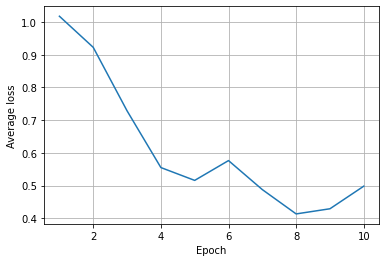

In [8]:
plot_loss(losses, num_epoch, len(train_loader), './figures/Loss model v4 study level.png')

## Test the model

In [9]:
# Load model for evaluation
trained_model = ModelV4()
trained_model.load_state_dict(torch.load('./models/model_v4.h5',))
trained_model.to(device)

ModelV4(
  (conv1): Conv2d(150, 256, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12544, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (sigmoid): Sigmoid()
)

In [10]:
accuracy, total = evaluate(trained_model, test_loader, device)

In [11]:
print(f'Accuracy of the network on the {total} test studies: {accuracy:.2f}')

Accuracy of the network on the 36 test studies: 75.00
